In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import jax
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jaxopt import ScipyMinimize
import passenger

In [2]:
prefixes = ["8a", "9a", "11a"]
output_prefix = "chigy_lc"
nt_base_start = 336
chigy_stop_trimmed = passenger.CHIGY_LC_STOP_TRIMMED
chigy_codonable = chigy_stop_trimmed[:321]
output_dir = "output/"
output_path_prefix = output_dir+output_prefix

# These are positions that the individual notebooks showed had many Ns.
problem_positions = np.array([295, 306, 307, 319, 321])

# These need to be taken from the lengths of the chigy_believable dataframe lengths in the respective notebooks.
read_counts = jnp.array([8662, 45079, 74396])

In [3]:
fivemers = pd.read_csv('output/fivemers.csv')
fivemers.columns = ['Fivemer']
mut8a = pd.read_csv('output/8a_mut_freq.csv')
mut9a = pd.read_csv('output/9a_mut_freq.csv')
mut11a = pd.read_csv('output/11a_mut_freq.csv')
complete_df = pd.concat([fivemers, mut8a, mut9a, mut11a], axis=1)

mutability = pd.read_csv('../nextflow/data/mutability/MK_RS5NF_mutability.csv', sep=' ')
mutability_series = mutability.set_index('Fivemer')['Mutability']

complete_df['Mutability'] = complete_df['Fivemer'].map(mutability_series)

# set a lower threshold of 1e-6 for all mut_freq columns
complete_df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']] = complete_df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']].clip(lower=1e-5)
# get the min of each _mut_freq column
complete_df[['8a_mut_freq', '9a_mut_freq', '11a_mut_freq']].min(axis=0)


8a_mut_freq     0.000010
9a_mut_freq     0.000022
11a_mut_freq    0.000027
dtype: float64

In [4]:
assert passenger.matches_RGYW("AAGCT") == True


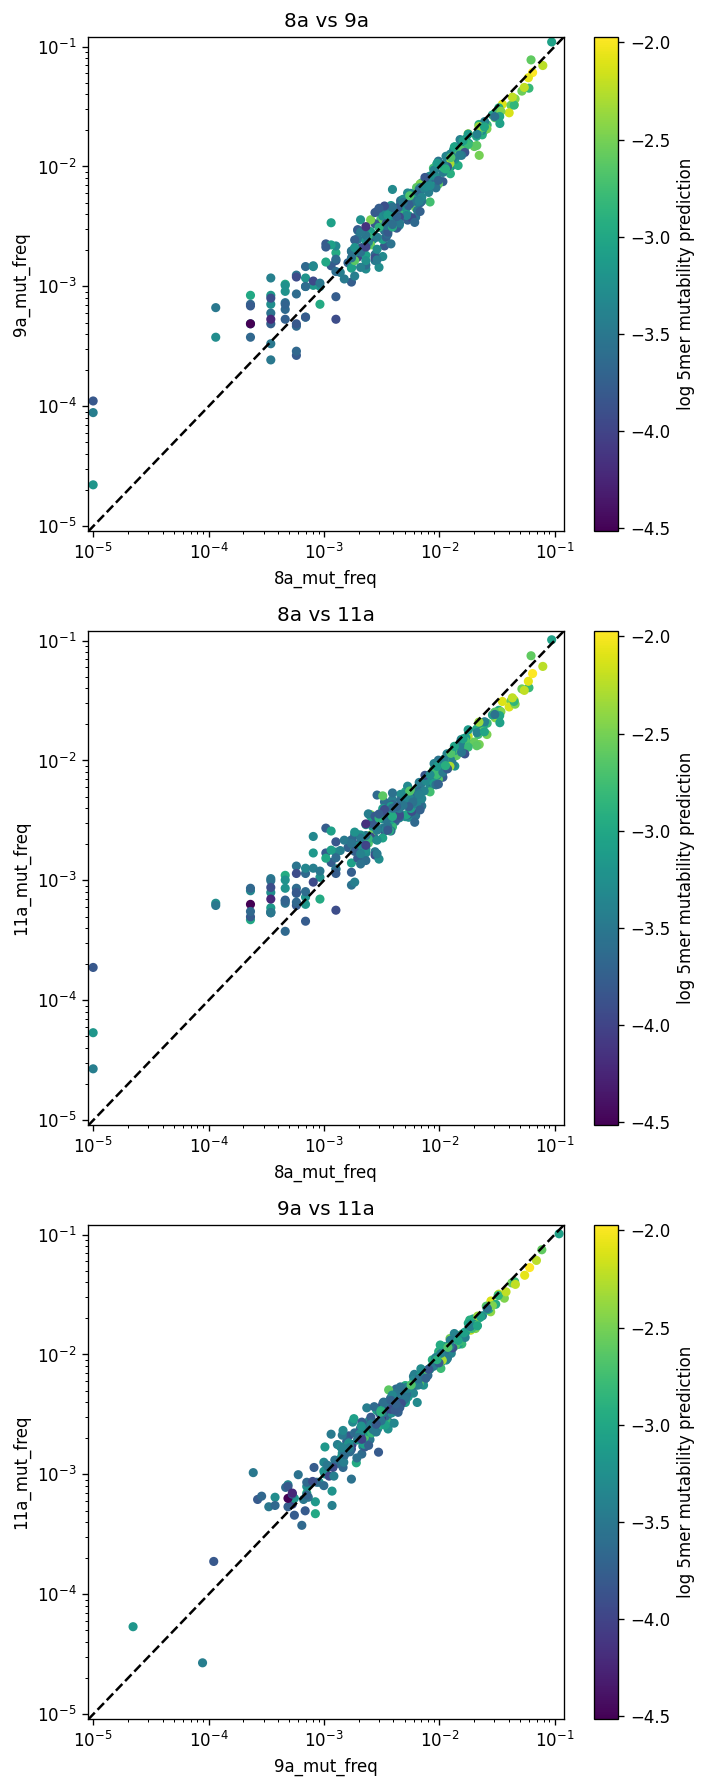

In [5]:
cbar_title = 'log 5mer mutability prediction'
df = complete_df.copy()
df[cbar_title] = np.log10(df['Mutability'])

min_limit = min(df['8a_mut_freq'].min(), df['9a_mut_freq'].min(), df['11a_mut_freq'].min())/1.1
max_limit = max(df['8a_mut_freq'].max(), df['9a_mut_freq'].max(), df['11a_mut_freq'].max())*1.1

def set_limits_and_styles(ax, title, min_limit, max_limit):
    ax.set_title(title)
    ax.set_xlim(min_limit, max_limit)
    ax.set_ylim(min_limit, max_limit)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min_limit, max_limit], [min_limit, max_limit], 'k--')  # Add x=y line


# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 15))

# Plot each scatter plot
df.plot.scatter(x='8a_mut_freq', y='9a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=axs[0])
set_limits_and_styles(axs[0], '8a vs 9a', min_limit, max_limit)

df.plot.scatter(x='8a_mut_freq', y='11a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=axs[1])
set_limits_and_styles(axs[1], '8a vs 11a', min_limit, max_limit)

df.plot.scatter(x='9a_mut_freq', y='11a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=axs[2])
set_limits_and_styles(axs[2], '9a vs 11a', min_limit, max_limit)

plt.tight_layout()
plt.show()


Text(0, 0.5, '11a mutation rate per site')

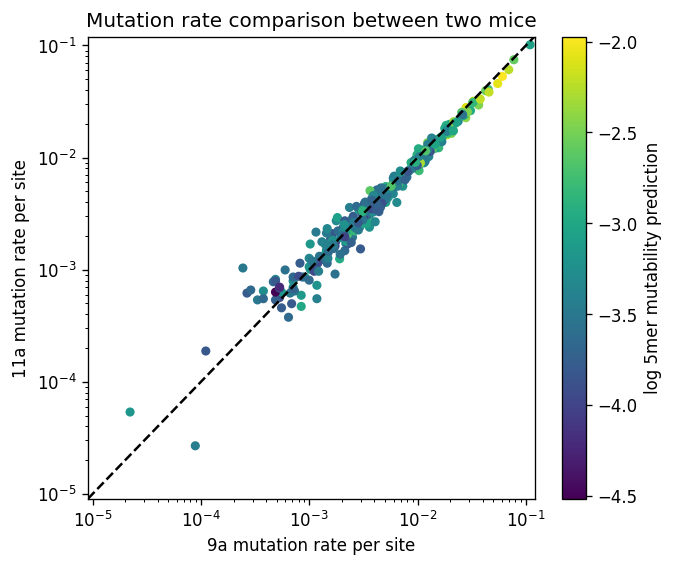

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

df.plot.scatter(x='9a_mut_freq', y='11a_mut_freq', c=cbar_title, colormap='viridis', loglog=True, ax=ax)
set_limits_and_styles(ax, '9a vs 11a', min_limit, max_limit)
plt.title("Mutation rate comparison between two mice")
plt.xlabel("9a mutation rate per site")
plt.ylabel("11a mutation rate per site")
# fig.savefig('passenger_9a_vs_11a.svg', format='svg', dpi=300)

## Combining information across the three experiments

### Substitution

Because the substitution matrix is simply a categorical on bases conditioned on a substitution, we don't have to worry about varying mutation load between the data sets.

In [7]:
pseudocount = 0.5

by_base_dfs = {}
for prefix in prefixes:
    by_base_dfs[prefix] = pd.read_csv(f'{output_dir}/{prefix}_counts_by_base.csv', index_col=0)
    by_base_dfs[prefix] = by_base_dfs[prefix].replace(-1, float("nan"))
    assert by_base_dfs[prefix].min().min() >= 0

# total these dfs
by_base_df = sum(df for df in by_base_dfs.values())

by_base_df += pseudocount
# replace all nans by 0
by_base_df = by_base_df.fillna(0)
by_base_df = by_base_df.div(by_base_df.sum(axis=1), axis=0)
by_base_df.to_csv(output_path_prefix+"_substitution.csv")
by_base_df

,A,C,G,T
0,0.333333,0.333333,0.000000,0.333333
1,0.000000,0.070270,0.308108,0.621622
2,0.492386,0.000000,0.299492,0.208122
3,0.000000,0.084800,0.286400,0.628800
4,0.277810,0.523588,0.198602,0.000000
...,...,...,...,...
317,0.000000,0.142007,0.582210,0.275784
318,0.000000,0.230577,0.597009,0.172414
319,0.000000,0.017512,0.096524,0.885964
320,0.000000,0.076923,0.538462,0.384615


### Mutability

Let $i$ index the sites, and $j$ represent the experiment.
We will use the notation:

* $n_{ij}$: the number of mutations observed at site $i$ in experiment $j$
* $r_i$: the rate of mutation at site $i$
* $\lambda_j$: the Poisson offset for experiment $j$ representing the length of the period of affinity maturation
* $s_j$: the sequencing depth of experiment $j$

We will model

$$
n_{ij} \sim \operatorname{Pois}(r_i \lambda_j s_j)
$$

The log likelihood for this model across all sites and experiments will be 

$$
C + \sum_{i,j} \left[n_{ij} \log(r_i \lambda_j s_j) - r_i \lambda_j s_j \right]
$$

In [8]:
by_site_df = pd.DataFrame({name: df.sum(axis=1, skipna=True) for name, df in by_base_dfs.items()})
by_site_df

,8a,9a,11a
0,0.0,4.0,2.0
1,3.0,11.0,77.0
2,3.0,53.0,41.0
3,28.0,80.0,203.0
4,72.0,331.0,454.0
...,...,...,...
317,290.0,1028.0,1536.0
318,98.0,430.0,674.0
319,815.0,4918.0,7542.0
320,0.0,1.0,4.0


In [9]:
site_count = by_site_df.shape[0]
experiment_count = by_site_df.shape[1]

def neg_log_likelihood(params, n_ij, s_j):
    log_r_i, log_lambda_j = params[:site_count], params[site_count:]
    lambda_j = jnp.exp(log_lambda_j)
    r_i = jax.nn.softmax(log_r_i)
    expected = r_i[:, None] * lambda_j[None, :] * s_j[None, :]
    ll = n_ij * jnp.log(expected) - expected
    return -jnp.sum(ll)

n_ij = jnp.array(by_site_df)
initial_params = jnp.log(jnp.ones(site_count + experiment_count))

neg_log_likelihood(initial_params, n_ij, read_counts)

Array(-1533123.06661577, dtype=float64)

In [10]:
# Set up the optimizer
optimizer = ScipyMinimize(fun=neg_log_likelihood, method='BFGS')
result = optimizer.run(initial_params, n_ij=n_ij, s_j=read_counts)

# Extract the optimized parameters
opt_params = result.params
r_i_opt = jax.nn.softmax(opt_params[:site_count])
lambda_j_opt = jnp.exp(opt_params[site_count:])

print("Optimized lambda_j:", lambda_j_opt)
opt_likelihood = neg_log_likelihood(opt_params, n_ij, read_counts)

complete_df["fit_rate"] = r_i_opt

Optimized lambda_j: [2.93142462 2.64051997 2.44365288]


We see good concordance with just the normalized frequency using the 11a data:

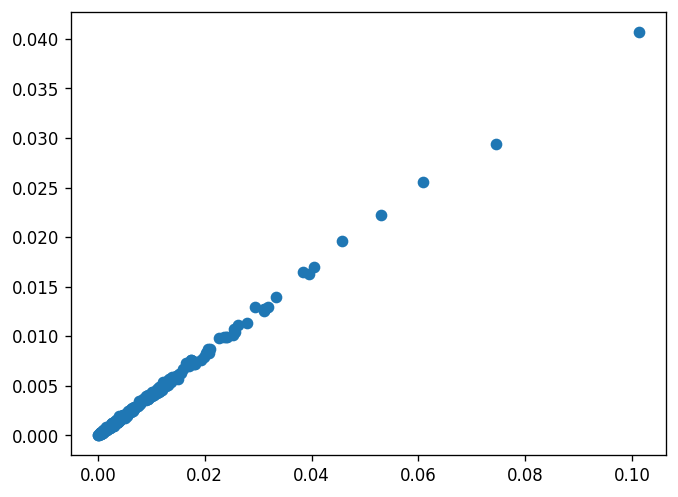

In [11]:
plt.scatter(complete_df["11a_mut_freq"], complete_df["fit_rate"])

## Correcting problem positions

### Substitution probabilities

In [12]:
fivemer_subs = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=' ')

fivemer_subs.set_index('Fivemer', inplace=True)

fivemer_subs = fivemer_subs.loc[df['Fivemer']].reset_index()

fivemer_subs

,Fivemer,A,C,G,T
0,NNGAC,0.809627,0.080776,0.000000,0.109597
1,NGACA,0.000000,0.190511,0.604532,0.204957
2,GACAT,0.105263,0.000000,0.263158,0.631579
3,ACATT,0.000000,0.105263,0.447368,0.447368
4,CATTG,0.240000,0.520000,0.240000,0.000000
...,...,...,...,...,...
317,ATAAA,0.000000,0.118519,0.585185,0.296296
318,TAAAA,0.000000,0.170259,0.721983,0.107759
319,AAAAC,0.000000,0.191268,0.704782,0.103950
320,AAACN,0.000000,0.131992,0.617877,0.250131


In [13]:
# for every index in problem_positions, get the A, C, G, T columns from fivemer_subs and replace the corresponding columns of df with them
for i in problem_positions:
    by_base_df.iloc[i, :] = fivemer_subs.iloc[i, 1:]
    
by_base_df

,A,C,G,T
0,0.333333,0.333333,0.000000,0.333333
1,0.000000,0.070270,0.308108,0.621622
2,0.492386,0.000000,0.299492,0.208122
3,0.000000,0.084800,0.286400,0.628800
4,0.277810,0.523588,0.198602,0.000000
...,...,...,...,...
317,0.000000,0.142007,0.582210,0.275784
318,0.000000,0.230577,0.597009,0.172414
319,0.000000,0.191268,0.704782,0.103950
320,0.000000,0.076923,0.538462,0.384615


### Mutability

In [14]:
# set the rate of the problematic positions to nan
complete_df.loc[problem_positions, "fit_rate"] = np.nan
# sum of df["fit_rate"], ignoring nan values
fit_rate_sum = complete_df["fit_rate"].sum(skipna=True)
complete_df["rate"] = complete_df["fit_rate"]/fit_rate_sum
complete_df["normed_s5f"] = complete_df["Mutability"] / sum(complete_df["Mutability"])

complete_df.loc[problem_positions, "rate"] = complete_df.loc[problem_positions, "normed_s5f"]

complete_df

,Fivemer,8a_mut_freq,9a_mut_freq,11a_mut_freq,Mutability,fit_rate,rate,normed_s5f
0,NNGAC,0.000010,0.000089,0.000027,0.000367,0.000018,0.000020,0.001264
1,NGACA,0.000346,0.000244,0.001035,0.000321,0.000279,0.000308,0.001106
2,GACAT,0.000346,0.001176,0.000551,0.000384,0.000297,0.000329,0.001324
3,ACATT,0.003233,0.001775,0.002729,0.000493,0.000953,0.001054,0.001698
4,CATTG,0.008312,0.007343,0.006102,0.000496,0.002627,0.002904,0.001708
...,...,...,...,...,...,...,...,...
317,ATAAA,0.033480,0.022804,0.020646,0.000867,0.008749,0.009672,0.002986
318,TAAAA,0.011314,0.009539,0.009060,0.001240,0.003685,0.004073,0.004272
319,AAAAC,0.094089,0.109097,0.101376,0.000865,NaN,0.002979,0.002979
320,AAACN,0.000010,0.000022,0.000054,0.000656,0.000015,0.000017,0.002259


In [15]:
complete_df = pd.concat([complete_df, by_base_df * complete_df["rate"].values[:, None]], axis=1)
complete_df.index = complete_df.index + nt_base_start
complete_df

,Fivemer,8a_mut_freq,9a_mut_freq,11a_mut_freq,Mutability,fit_rate,rate,normed_s5f,A,C,G,T
336,NNGAC,0.000010,0.000089,0.000027,0.000367,0.000018,0.000020,0.001264,0.000007,0.000007,0.000000,0.000007
337,NGACA,0.000346,0.000244,0.001035,0.000321,0.000279,0.000308,0.001106,0.000000,0.000022,0.000095,0.000192
338,GACAT,0.000346,0.001176,0.000551,0.000384,0.000297,0.000329,0.001324,0.000162,0.000000,0.000098,0.000068
339,ACATT,0.003233,0.001775,0.002729,0.000493,0.000953,0.001054,0.001698,0.000000,0.000089,0.000302,0.000663
340,CATTG,0.008312,0.007343,0.006102,0.000496,0.002627,0.002904,0.001708,0.000807,0.001521,0.000577,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
653,ATAAA,0.033480,0.022804,0.020646,0.000867,0.008749,0.009672,0.002986,0.000000,0.001373,0.005631,0.002667
654,TAAAA,0.011314,0.009539,0.009060,0.001240,0.003685,0.004073,0.004272,0.000000,0.000939,0.002432,0.000702
655,AAAAC,0.094089,0.109097,0.101376,0.000865,NaN,0.002979,0.002979,0.000000,0.000570,0.002099,0.000310
656,AAACN,0.000010,0.000022,0.000054,0.000656,0.000015,0.000017,0.002259,0.000000,0.000001,0.000009,0.000007


In [16]:
complete_df.to_csv(f"{output_path_prefix}_mutation_rates_nt.csv", columns=["Fivemer", "A", "C", "G", "T"])
complete_df.to_csv(f"{output_path_prefix}_mutation_rates_nt_extras.csv", columns=["Fivemer", "rate", "normed_s5f", "A", "C", "G", "T"])

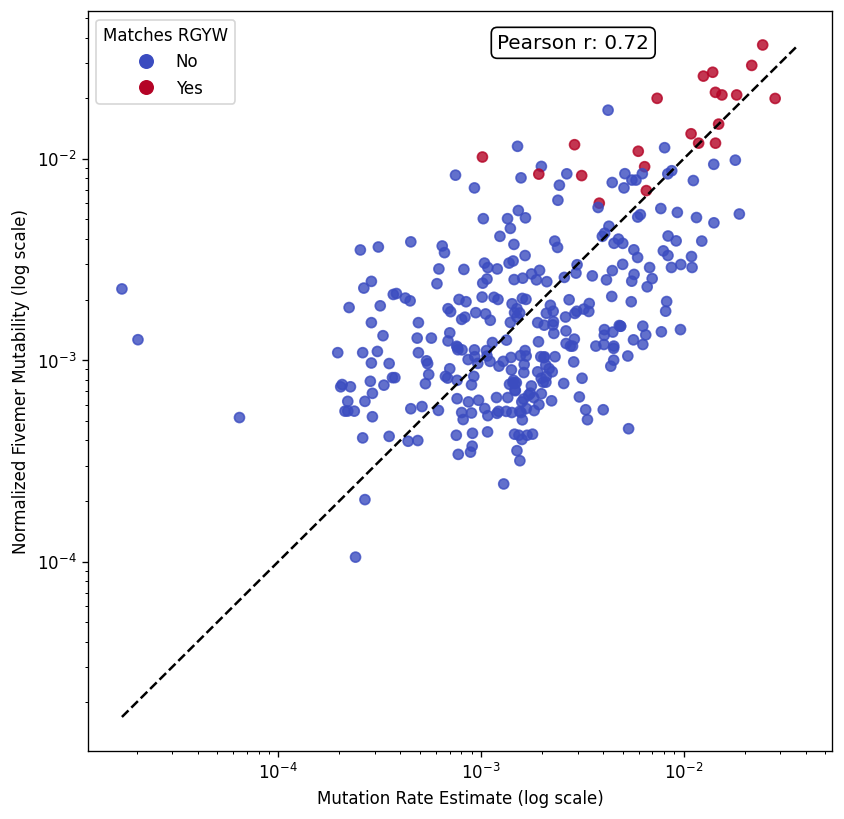

In [17]:
# Apply the matches_RGYW function to the 'Fivemer' column
complete_df['matches_RGYW'] = complete_df['Fivemer'].apply(passenger.matches_RGYW)

passenger.plot_mutation_rate_vs_normed_s5f(complete_df)